In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from torchvision.utils import make_grid
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image

In [130]:
import pytorch_lightning as pl

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.activation = nn.SiLU()

    def forward(self, x):
        return self.activation(x + self.block(x))

class DigitCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),

            ResidualBlock(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),

            ResidualBlock(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),

            nn.Dropout2d(0.25),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

class LitDigitCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = DigitCNN()

    def forward(self, x):
        return self.model(x)

PATH = "chk/CNN2_1607_e30_OneCycleLR9/best.ckpt"

model = LitDigitCNN.load_from_checkpoint(PATH)
model.eval()
device = "cpu"
model.to(device)


LitDigitCNN(
  (model): DigitCNN(
    (features): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (activation): SiLU()
      )
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): SiLU()
      (7): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel

In [138]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def build_val_tf(img_size):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2()
    ])

val_transforms = build_val_tf(img_size=24)

class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform):
        self.dataset = datasets.ImageFolder(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        img = Image.open(path).convert("L")
        img = np.array(img)
        img = self.transform(image=img)["image"]
        return img, label, path

val_dataset = AlbumentationsDataset("dataset/val", val_transforms)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model.eval()
device = "cpu"

all_embeddings = []
all_labels = []
all_images = []
all_preds = []
all_losses = []
all_paths = []

with torch.no_grad():
    for x, y, paths in val_loader:
        x = x.to(device)
        y = y.to(device)

        features_map = model.model.features(x)
        emb = model.model.classifier[:2](features_map)
        dropped = model.model.classifier[2](emb)
        logits = model.model.classifier[3](dropped)

        loss = F.cross_entropy(logits, y, reduction='none')
        preds = torch.argmax(logits, dim=1)

        all_embeddings.append(emb.cpu())
        all_labels.append(y.cpu())
        all_images.append(x.cpu())
        all_preds.append(preds.cpu())
        all_losses.append(loss.cpu())
        all_paths.extend(paths)


embeddings = torch.cat(all_embeddings).numpy() # dim=0
labels = torch.cat(all_labels).numpy()
images = torch.cat(all_images)
preds = torch.cat(all_preds).numpy()
losses = torch.cat(all_losses).numpy()
paths = np.array(all_paths)


print(embeddings.shape)


(11999, 128)


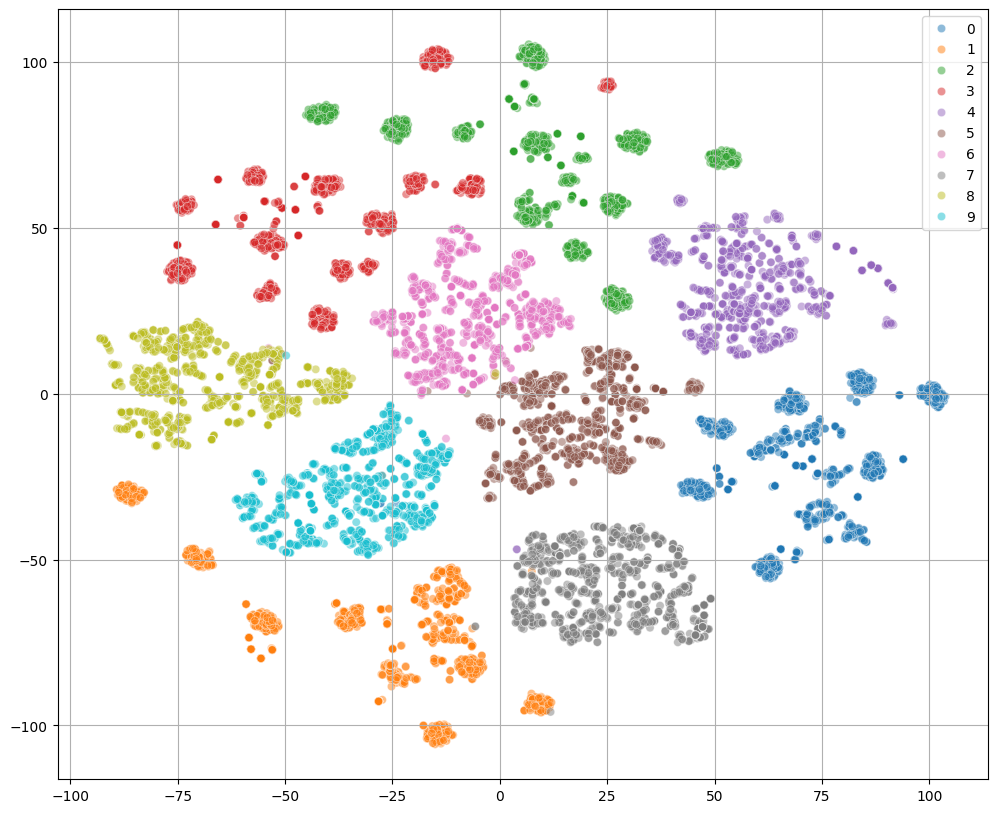

In [139]:
embs = TSNE(n_components=2, perplexity=30).fit_transform(embeddings)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=embs[:, 0], y=embs[:, 1], hue=labels, palette='tab10', alpha = 0.5)
plt.legend(loc="best")
plt.grid(True)
plt.show()


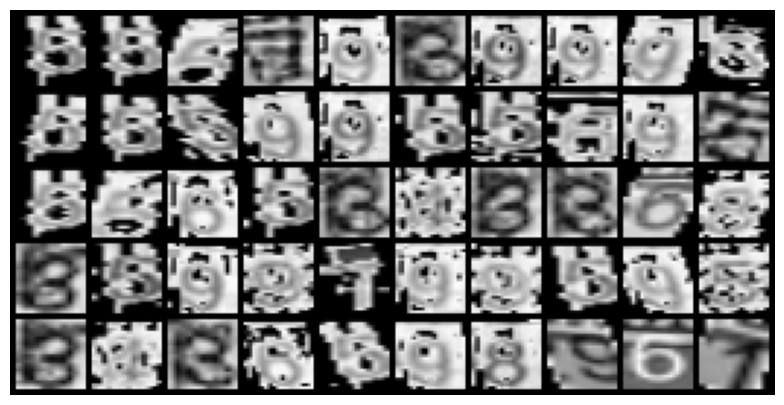

[1] dataset/val\5\aug_92_3.png
[1] True: 5; Predicted: 8; Loss: 4.0640
[2] dataset/val\5\aug_95_4.png
[2] True: 5; Predicted: 8; Loss: 3.5280
[3] dataset/val\5\aug_114_3.png
[3] True: 5; Predicted: 6; Loss: 2.9195
[4] dataset/val\7\aug_12_2.png
[4] True: 7; Predicted: 1; Loss: 2.7453
[5] dataset/val\9\aug_25_18.png
[5] True: 9; Predicted: 1; Loss: 2.3056
[6] dataset/val\3\aug_3_0.png
[6] True: 3; Predicted: 8; Loss: 2.2801
[7] dataset/val\9\aug_25_6.png
[7] True: 9; Predicted: 8; Loss: 2.2554
[8] dataset/val\9\aug_25_0.png
[8] True: 9; Predicted: 8; Loss: 2.2537
[9] dataset/val\9\aug_22_9.png
[9] True: 9; Predicted: 8; Loss: 2.1685
[10] dataset/val\5\aug_126_0.png
[10] True: 5; Predicted: 8; Loss: 2.1266
[11] dataset/val\5\aug_81_4.png
[11] True: 5; Predicted: 8; Loss: 2.0142
[12] dataset/val\5\aug_65_4.png
[12] True: 5; Predicted: 6; Loss: 1.9892
[13] dataset/val\5\aug_75_0.png
[13] True: 5; Predicted: 9; Loss: 1.9591
[14] dataset/val\9\aug_12_11.png
[14] True: 9; Predicted: 8; Loss: 

In [140]:
N = 50
topk_indices = np.argsort(-losses)[:N]
worst_imgs = images[topk_indices]
worst_preds = preds[topk_indices]
worst_labels = labels[topk_indices]
worst_paths = paths[topk_indices]

plt.figure(figsize=(10, 5))
grid = make_grid(worst_imgs, nrow=10, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

for i in range(N):
    print(f"[{i+1}] {worst_paths[i]}")
    print(f"[{i+1}] True: {worst_labels[i]}; Predicted: {worst_preds[i]}; Loss: {losses[topk_indices[i]]:.4f}")



In [141]:

with open("predictions.txt", "w", encoding="utf-8") as f:
    for i in range(N):
        f.write(f"[{i+1}] Файл: {worst_paths[i]}\n")
        f.write(f"[{i+1}] True: {worst_labels[i]}; Predicted: {worst_preds[i]}; Loss: {losses[topk_indices[i]]:.4f}\n")


## датасет без аугментаций

In [136]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def build_val_tf(img_size):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2()
    ])

val_transforms = build_val_tf(img_size=24)

class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform):
        self.dataset = datasets.ImageFolder(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        img = Image.open(path).convert("L")
        img = np.array(img)
        img = self.transform(image=img)["image"]
        return img, label, path

val_dataset = AlbumentationsDataset("dataset_clear/val", val_transforms)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model.eval()
device = "cpu"

all_embeddings = []
all_labels = []
all_images = []
all_preds = []
all_losses = []
all_paths = []

with torch.no_grad():
    for x, y, paths in val_loader:
        x = x.to(device)
        y = y.to(device)

        features_map = model.model.features(x)
        emb = model.model.classifier[:2](features_map)
        dropped = model.model.classifier[2](emb)
        logits = model.model.classifier[3](dropped)

        loss = F.cross_entropy(logits, y, reduction='none')
        preds = torch.argmax(logits, dim=1)

        all_embeddings.append(emb.cpu())
        all_labels.append(y.cpu())
        all_images.append(x.cpu())
        all_preds.append(preds.cpu())
        all_losses.append(loss.cpu())
        all_paths.extend(paths)


embeddings = torch.cat(all_embeddings).numpy() # dim=0
labels = torch.cat(all_labels).numpy()
images = torch.cat(all_images)
preds = torch.cat(all_preds).numpy()
losses = torch.cat(all_losses).numpy()
paths = np.array(all_paths)


print(embeddings.shape)


(4805, 128)


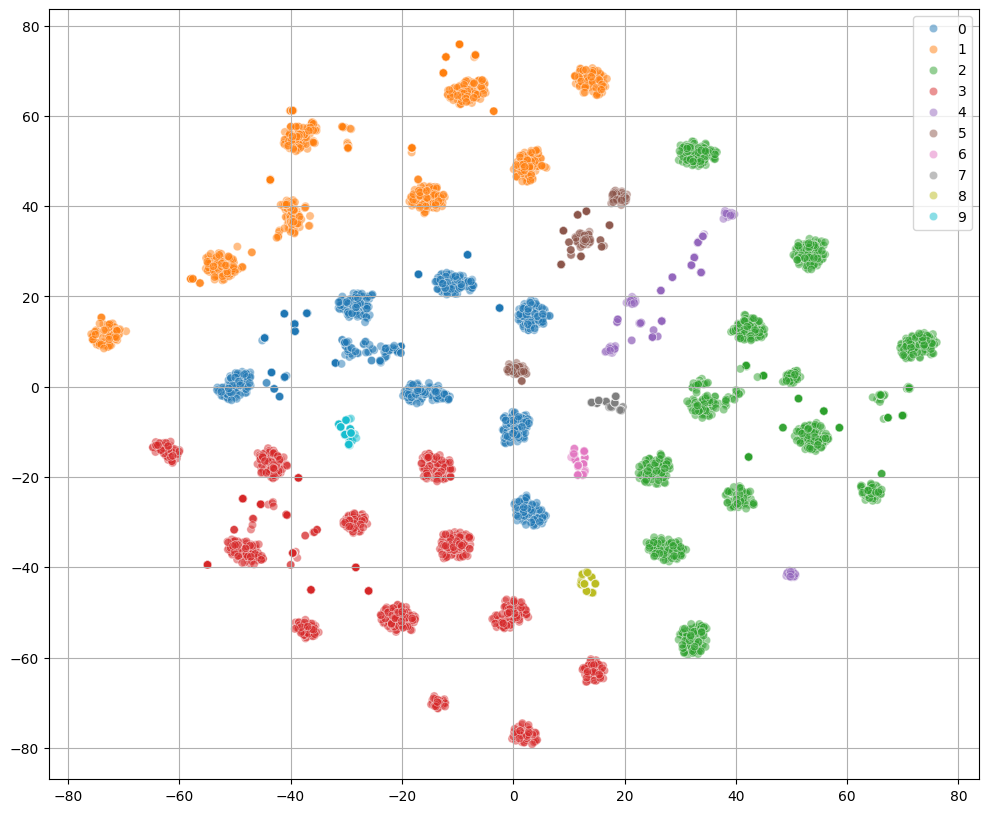

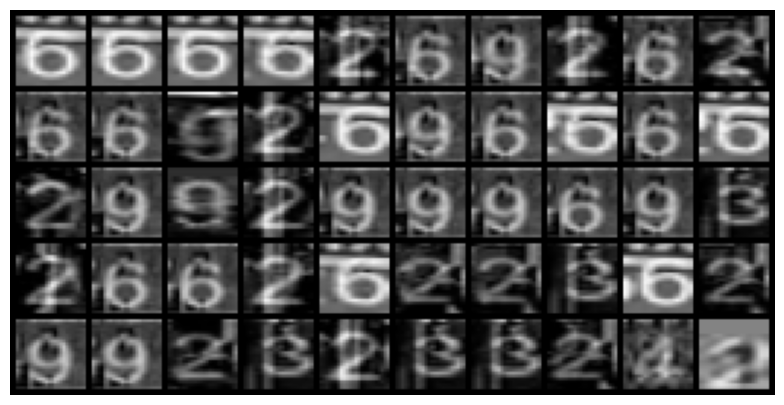

[1] dataset_clear/val\6\cam_3245_02_1739435409_0_time_char_frame_702_pos_5.png
[1] True: 6; Predicted: 6; Loss: 1.1813
[2] dataset_clear/val\6\cam_3245_02_1739435409_0_time_char_frame_162_pos_5.png
[2] True: 6; Predicted: 6; Loss: 1.0708
[3] dataset_clear/val\6\cam_3245_02_1739435409_0_time_char_frame_1782_pos_5.png
[3] True: 6; Predicted: 6; Loss: 0.9899
[4] dataset_clear/val\6\cam_3245_02_1739435409_0_time_char_frame_1512_pos_5.png
[4] True: 6; Predicted: 6; Loss: 0.8506
[5] dataset_clear/val\2\cam_3245_20_1739435409_1_date_char_frame_2214_pos_4.png
[5] True: 2; Predicted: 2; Loss: 0.7778
[6] dataset_clear/val\6\cam_3245_10_1739435409_0_time_char_frame_972_pos_5.png
[6] True: 6; Predicted: 6; Loss: 0.7011
[7] dataset_clear/val\9\cam_3245_10_1739435409_0_time_char_frame_1917_pos_5.png
[7] True: 9; Predicted: 9; Loss: 0.6208
[8] dataset_clear/val\2\cam_3245_20_1739435409_1_date_char_frame_2052_pos_4.png
[8] True: 2; Predicted: 2; Loss: 0.5737
[9] dataset_clear/val\6\cam_3245_10_1739435

In [137]:
embs = TSNE(n_components=2, perplexity=30).fit_transform(embeddings)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=embs[:, 0], y=embs[:, 1], hue=labels, palette='tab10', alpha = 0.5)
plt.legend(loc="best")
plt.grid(True)
plt.show()

N = 50
topk_indices = np.argsort(-losses)[:N]
worst_imgs = images[topk_indices]
worst_preds = preds[topk_indices]
worst_labels = labels[topk_indices]
worst_paths = paths[topk_indices]

plt.figure(figsize=(10, 5))
grid = make_grid(worst_imgs, nrow=10, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

for i in range(N):
    print(f"[{i+1}] {worst_paths[i]}")
    print(f"[{i+1}] True: {worst_labels[i]}; Predicted: {worst_preds[i]}; Loss: {losses[topk_indices[i]]:.4f}")


with open("predictions_clear.txt", "w", encoding="utf-8") as f:
    for i in range(N):
        f.write(f"[{i+1}] Файл: {worst_paths[i]}\n")
        f.write(f"[{i+1}] True: {worst_labels[i]}; Predicted: {worst_preds[i]}; Loss: {losses[topk_indices[i]]:.4f}\n")
